In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import *
sys.path.append('/data/nihaifeng/code/HeliosArtifact/simulator')
import utils

sns.set_style("ticks")
font = {
	"font.family": "Roboto",
	"font.size": 14,
}
sns.set_style(font)
paper_rc = {
	"lines.linewidth": 2.5,
	"lines.markersize": 10,
}
sns.set_context("paper", font_scale=1.6, rc=paper_rc)
current_palette = sns.color_palette()
pd.set_option("display.max_columns", None)

In [17]:
for color in current_palette:
    print(color)

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
(1.0, 0.4980392156862745, 0.054901960784313725)
(0.17254901960784313, 0.6274509803921569, 0.17254901960784313)
(0.8392156862745098, 0.15294117647058825, 0.1568627450980392)
(0.5803921568627451, 0.403921568627451, 0.7411764705882353)
(0.5490196078431373, 0.33725490196078434, 0.29411764705882354)
(0.8901960784313725, 0.4666666666666667, 0.7607843137254902)
(0.4980392156862745, 0.4980392156862745, 0.4980392156862745)
(0.7372549019607844, 0.7411764705882353, 0.13333333333333333)
(0.09019607843137255, 0.7450980392156863, 0.8117647058823529)


In [88]:
data_name = ['PAI', 'Philly', 'Venus']
xticks = [[0, 10, 15, 20, 30 , 40], [0, 15, 30, 45, 60],  [0, 10, 15, 20, 26]]
schedulers = ["fifo_consolidate", "fifo_FGD", "fifo_stBestFit", "gandiva_new", "defragS_fifo_stBestFit"]
labels = ['BestFit', 'FGD', "St-BestFit", 'Gandiva', 'DeFragS']
log_dir = '../log/new'
colors = [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), 
		  (1.0, 0.4980392156862745, 0.054901960784313725),
		  (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
		  (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
		  (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
		  ]

window_size = 60 * 24
data_type = 'fragmentation_ratio' #  gpu_utilization 


linestyles = [":", "--", "-", "-.", "--"]
ax_number = ['a', 'b', 'c']

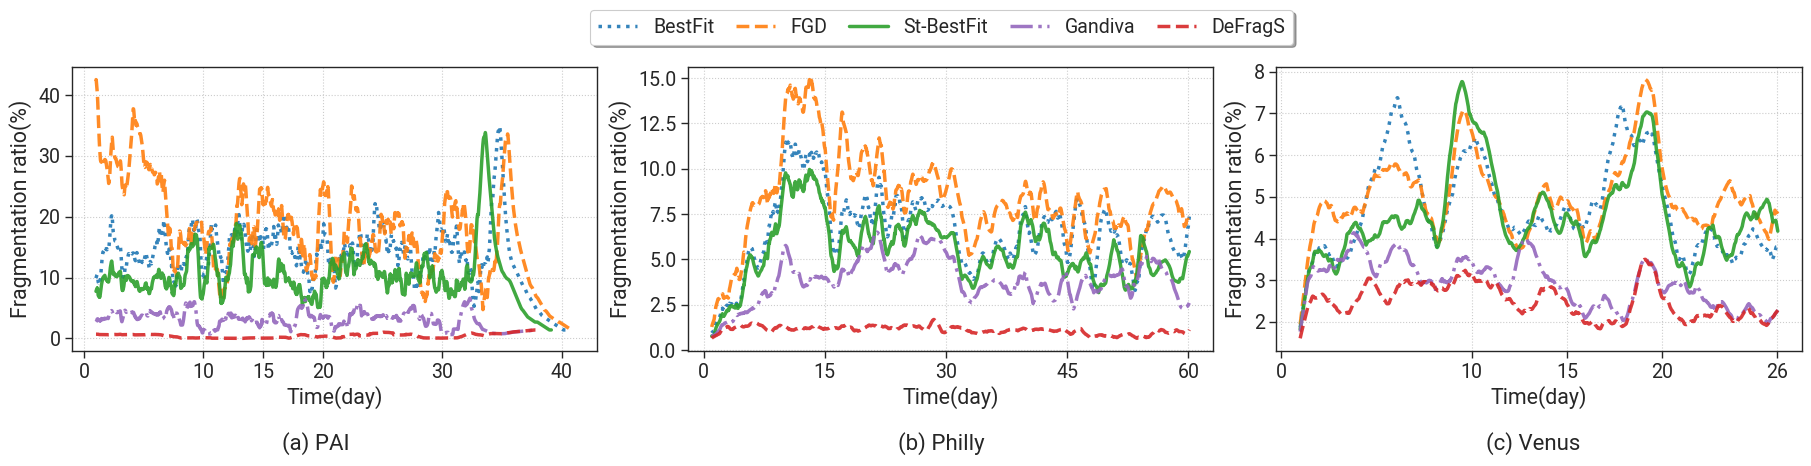

In [53]:
# fragmentation ration & gpu utilization
fig, axes = plt.subplots(ncols=3, nrows=1, constrained_layout=True, figsize=(18, 4))

for i, data in enumerate(data_name):
	ax = axes[i]
	for j, scheduler in enumerate(schedulers):
		if data == 'PAI':
			df = pd.read_csv(log_dir+f'/ali20/ali20_{scheduler}/all/{scheduler}_all_seq.csv')
		elif data == 'Philly':
			df = pd.read_csv(log_dir+f'/Philly/Philly_{scheduler}/all/{scheduler}_all_seq.csv')
		elif data == 'Venus':
			df = pd.read_csv(log_dir+f'/Venus_Sept/Venus_Sept_{scheduler}/all/{scheduler}_all_seq.csv')
		y = df[data_type] *100
		y_mean = y.rolling(window=window_size).mean()
		ax.plot(range(len(y_mean)), y_mean, linestyles[j], alpha=0.9, label=labels[j], color=colors[j])
	
	ax.set_xlabel(f"Time(day)")
	ax.set_ylabel(f"Fragmentation ratio(%)")
	#ax.legend(loc="upper right")

	ax.set_xticks([tick * window_size for tick in xticks[i]])
	ax.set_xticklabels(xticks[i])
	ax.grid(linestyle=":")
	ax.text(0.4, -0.35, f"({ax_number[i]}) {data}", transform=ax.transAxes, size=16)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center",bbox_to_anchor=(0.52, 1.15),ncol=5, columnspacing=1.1, fancybox=True,shadow=True,)
save = True
if save:
	fig.savefig(f"../figures/experiment1_fragmenation_ration.pdf", bbox_inches="tight", dpi=600,)

(5, 3)


/tmp/ipykernel_441458/3666737958.py:35: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0.1)


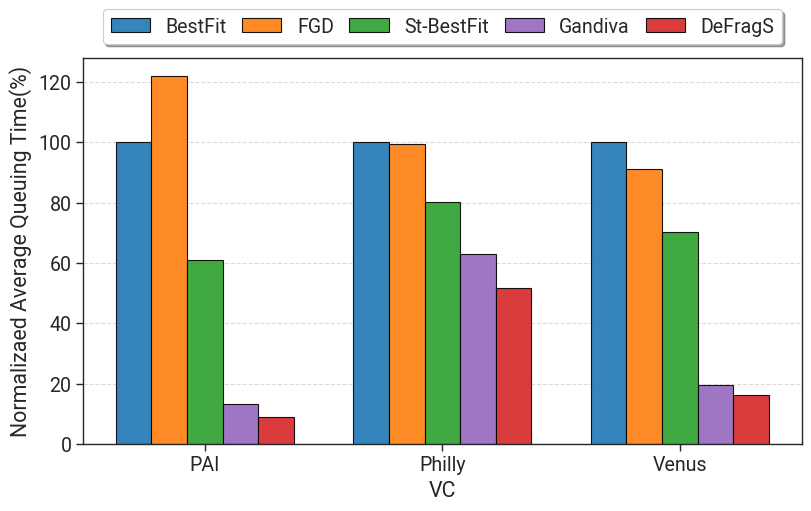

In [90]:

fig, (ax1) = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(8, 5))
x = np.arange(len(data_name))
width = 0.15

shcedulers_data = []
improvement_ratios = []
for i, data in enumerate(data_name):
	que_ls = []
	for j, scheduler in enumerate(schedulers):
		if data == 'PAI':
			df = pd.read_csv(log_dir+f'/ali20/ali20_{scheduler}/que_avg.csv')
		elif data == 'Philly':
			df = pd.read_csv(log_dir+f'/Philly/Philly_{scheduler}/que_avg.csv')
		elif data == 'Venus':
			df = pd.read_csv(log_dir+f'/Venus_Sept/Venus_Sept_{scheduler}/que_avg.csv')
		que_ls.append(df.iloc[len(df)-1, 1])

	# Normalize the queuing time
	que_ls = np.array(que_ls) / que_ls[0] * 100
	shcedulers_data.append(que_ls)

# 1. Draw Queue of different schedulers in each VC
scheduler_data = np.array(shcedulers_data).T
for i in range(len(schedulers)):
	ax1.bar(x + width * (i-2), scheduler_data[i], width, alpha=0.9,linewidth=0.8,edgecolor="k", label=labels[i], color=colors[i])

ax1.set_xlabel('VC')
ax1.set_xticks(x)
ax1.set_xticklabels(data_name)
ax1.set_ylabel('Normalizaed Average Queuing Time(%)')
ax1.legend(loc="upper center",bbox_to_anchor=(0.5, 1.15),ncol=5, columnspacing=0.8, fancybox=True,shadow=True,)
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.subplots_adjust(wspace=0.1) 
save = False
if save:
	fig.savefig(f"../figures/experiment2_QueuingTime_analysis.pdf", bbox_inches="tight", dpi=600,)

/tmp/ipykernel_441458/2679513252.py:44: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0.1)


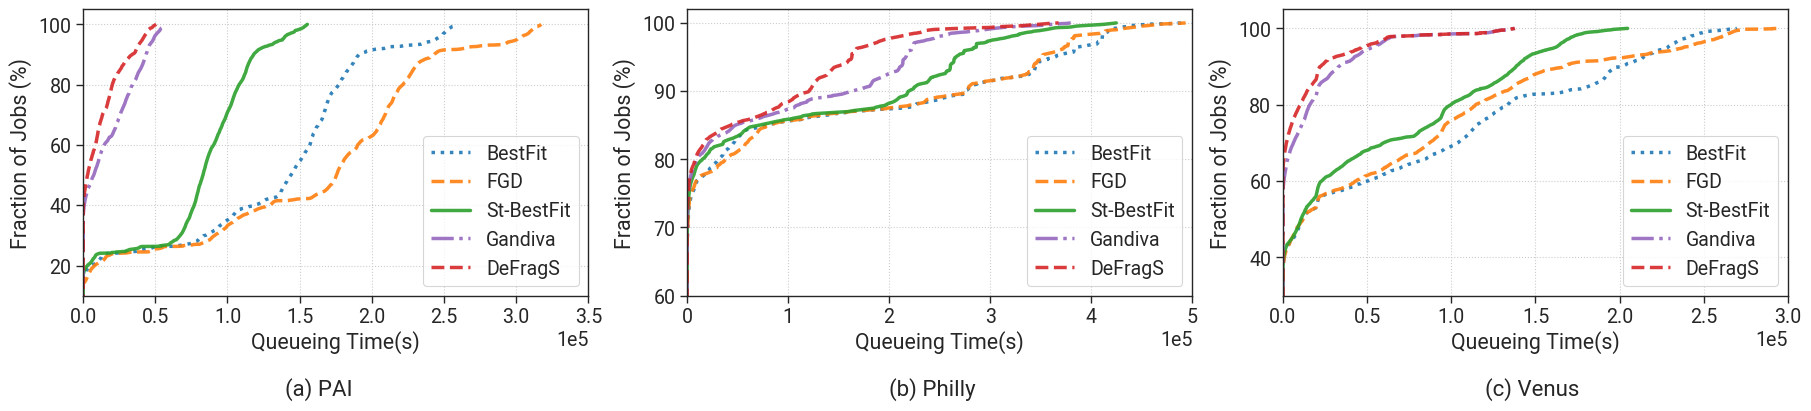

In [ ]:

fig, axes = plt.subplots(ncols=3, nrows=1, constrained_layout=True, figsize=(18, 4))
x = np.arange(len(data_name))
width = 0.15

dfs = []
for i, data in enumerate(data_name):
	ls = []
	for j, scheduler in enumerate(schedulers):
		if data == 'PAI':
			ls.append(pd.read_csv(log_dir+f'/ali20/ali20_{scheduler}/all/{scheduler}_all_log.csv'))
		elif data == 'Philly':
			ls.append(pd.read_csv(log_dir+f'/Philly/Philly_{scheduler}/all/{scheduler}_all_log.csv'))
		elif data == 'Venus':
			ls.append(pd.read_csv(log_dir+f'/Venus_Sept/Venus_Sept_{scheduler}/all/{scheduler}_all_log.csv'))
	dfs.append(ls)

for i, vc in enumerate(data_name):
# 2. Draw Queue CDF of Venus
	for idx, scheduler in enumerate(schedulers):
		y = dfs[i][idx]['queue']
		sorted_y = np.sort(y)
		# sorted_y = sorted_y[:int(len(sorted_y)*0.99)]    
		cdf = np.arange(1, len(sorted_y) + 1) / len(sorted_y) * 100
		axes[i].plot(sorted_y, cdf, linestyles[idx], alpha=0.9, label=labels[idx], color=colors[idx])

for i in range(len(axes)): 
	axes[i].set_xlabel("Queueing Time(s)")
	axes[i].set_ylabel("Fraction of Jobs (%)")
	if i ==0:
		axes[i].set_ylim(10, 105)
		axes[i].set_xlim(0, 350000)
	elif i ==1:
		axes[i].set_ylim(60, 102)
		axes[i].set_xlim(0, 500000)
	elif i ==2:
		axes[i].set_ylim(30, 105)
		axes[i].set_xlim(0, 300000)
	axes[i].ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
	axes[i].legend(loc="lower right")
	axes[i].grid(linestyle=":")

	axes[i].text(0.4, -0.35, f"({ax_number[i]}) {data_name[i]}", transform=axes[i].transAxes, size=16)

plt.subplots_adjust(wspace=0.1) 

save = True
if save:
	fig.savefig(f"../figures/experiment2_QueuingTime_cdf.pdf", bbox_inches="tight", dpi=600,)

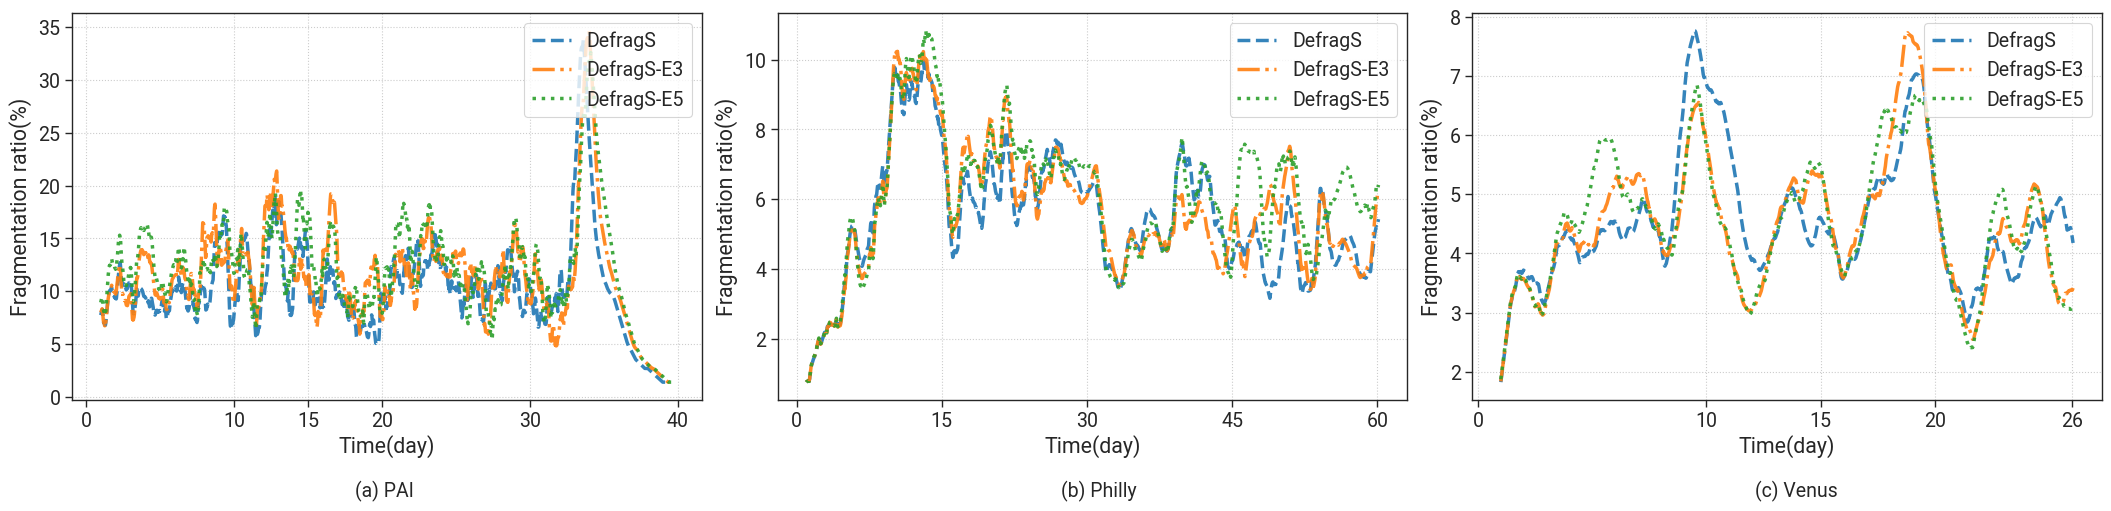

In [91]:
# 实验4：鲁棒性，duration不可只知
scheduler = 'fifo_stBestFit'
log_dirs = ["../log/new", "../log/noDuration_3", "../log/noDuration_5"] #  
labels = ['DefragS', "DefragS-E3", "DefragS-E5"] #  
colors = [(0.17254901960784313, 0.6274509803921569, 0.17254901960784313),(1.0, 0.4980392156862745, 0.054901960784313725),(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)]

window_size = 60 * 24
data_type = 'fragmentation_ratio' #  gpu_utilization

fig, axes = plt.subplots(ncols=3, nrows=1, constrained_layout=True, figsize=(21, 5))
linestyles = ["--", "-.", ":", "--"]
ax_number = ['a', 'b', 'c']

for i, data in enumerate(data_name):
	ax = axes[i]
	for j, log_dir in enumerate(log_dirs):
		# if log_dir != "../log/new":
		# 	scheduler = "defragS_stBestFit"
		# else:
		# 	scheduler = "defragS_fifo_stBestFit"
		if data == 'PAI':
			df = pd.read_csv(log_dir+f'/ali20/ali20_{scheduler}/all/{scheduler}_all_seq.csv')
		elif data == 'Philly':
			df = pd.read_csv(log_dir+f'/Philly/Philly_{scheduler}/all/{scheduler}_all_seq.csv')
		elif data == 'Venus':
			df = pd.read_csv(log_dir+f'/Venus_Sept/Venus_Sept_{scheduler}/all/{scheduler}_all_seq.csv')
		y = df[data_type]*100
		y_mean = y.rolling(window=window_size).mean()
		ax.plot(range(len(y_mean)), y_mean, linestyles[j], alpha=0.9, label=labels[j])
		
	
	ax.set_xlabel(f"Time(day)")
	ax.set_ylabel(f"Fragmentation ratio(%)")
	ax.legend(loc="upper right")

	ax.set_xticks([tick * window_size for tick in xticks[i]])
	ax.set_xticklabels(xticks[i])
	ax.grid(linestyle=":")
	ax.text(0.45, -0.25, f"({ax_number[i]}) {data}", transform=ax.transAxes, size=14)

save = False
if save:
	fig.savefig(f"../figures/experiment4_noDuration_fragmentation_ratio.pdf", bbox_inches="tight", dpi=600,)

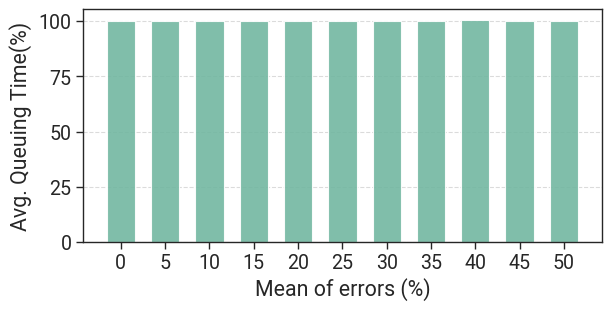

In [219]:
# 续实验4：鲁棒性，duration不可只知 画queuing time
scheduler = 'fifo_stBestFit'
data = 'ali20' # ali20, Philly, Venus_Sept
fig, (ax1) = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(6, 3), gridspec_kw={'hspace': 0.09})

labels = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
log_dirs = ["../log/new","../log/noDuration_05","../log/noDuration_1", "../log/noDuration_15","../log/noDuration_20",
			"../log/noDuration_25", "../log/noDuration_3", "../log/noDuration_35", "../log/noDuration_40", "../log/noDuration_45","../log/noDuration_5"]

que_ls = []
for j in range(len(log_dirs)):
	if j > 0:
		scheduler = "defragS_stBestFit"
	else:
		scheduler = "defragS_fifo_stBestFit"
	df = pd.read_csv(log_dirs[j]+f'/{data}/{data}_{scheduler}/que_avg.csv')
	que_ls.append(df.iloc[len(df)-1, 1])
	
# Normalize the queuing time base DefragS
que_ls = np.array(que_ls) / que_ls[0] * 100

ax1.bar(labels, que_ls, width=3.2, alpha=0.9, color="#72b7a1")
ax1.set_xlabel('Mean of errors (%)')
ax1.set_xticks(labels) 
ax1.set_ylabel('Avg. Queuing Time(%)')
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)

save = False
if save:  
	fig.savefig(f"../figures/noDuration_DFS.pdf", bbox_inches="tight", dpi=600,)

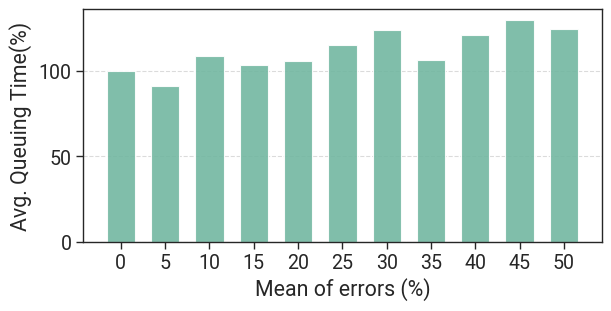

In [218]:
# 续实验4：鲁棒性，duration不可只知 画queuing time
scheduler = 'fifo_stBestFit'
data = 'ali20' # ali20, Philly, Venus_Sept
fig, (ax1) = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(6, 3), gridspec_kw={'hspace': 0.09})

labels = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
log_dirs = ["../log/new","../log/noDuration_05","../log/noDuration_1", "../log/noDuration_15","../log/noDuration_20",
			"../log/noDuration_25", "../log/noDuration_3", "../log/noDuration_35", "../log/noDuration_40", "../log/noDuration_45","../log/noDuration_5"]

que_ls = []
for j in range(len(log_dirs)):
	df = pd.read_csv(log_dirs[j]+f'/{data}/{data}_{scheduler}/que_avg.csv')
	que_ls.append(df.iloc[len(df)-1, 1])
	
# Normalize the queuing time base DefragS
que_ls = np.array(que_ls) / que_ls[0] * 100

ax1.bar(labels, que_ls, width=3.2, alpha=0.9, color="#72b7a1")

offset_x = -1.95  # 0.4
ax1.set_xlabel('Mean of errors (%)')
ax1.set_xticks(labels) 
ax1.set_ylabel('Avg. Queuing Time(%)')
# ax1.set_yticks([0, 25, 50, 75, 100, 125])
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)

save = False
if save:  
	fig.savefig(f"../figures/noDuration_St_Bf.pdf", bbox_inches="tight", dpi=600,)